## lslation Forest 孤立森林

In [1]:
#!/usr/bin/env python
#coding=utf-8
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# The below code defines classes for external and internal nodes
class ExNode():
    def __init__(self, size):
        self.size = size

class InNode():
    def __init__(self, left, right, splitAtt, splitVal):
        self.left = left
        self.right = right
        self.splitAtt = splitAtt
        self.splitVal = splitVal

<img src='iTree.png'>

In [3]:
# Isolation Tree
def iTree(X, currHeight, depth_lim):
    if currHeight >= depth_lim or len(X) <= 1:
        return ExNode(len(X))
    else:
        Q = X.columns
        q = random.choice(Q)
        p = random.choice(X[q].unique())
        X_left = X[X[q] < p]
        X_right = X[X[q] >= p]
        return InNode(iTree(X_left, currHeight+1, depth_lim), iTree(X_right, currHeight+1, depth_lim), q, p)

<img src='iForest.png'>

In [51]:
# iForest
def iForest(X, numOfTrees, samples_size):
    forest = []
    depth_lim = math.ceil(math.log(samples_size, 2))
    for i in xrange(numOfTrees):
        X_train = X.sample(samples_size)
        forest.append(iTree(X_train, 0, depth_lim))
    return forest

<img src='PathLength.png'>

In [43]:
# path length
def pathLength(x, Tree, currHeight):
    if isinstance(Tree, ExNode):
        return currHeight
    a = Tree.splitAtt
    if x[a] < Tree.splitVal:
        return pathLength(x, Tree.left, currHeight+1)
    else:
        return pathLength(x, Tree.right, currHeight+1)

In [44]:
data = pd.read_csv('~/person/analysis/python数据分析与数据化运营/chapter4/creditcard.csv')

In [45]:
y_true = data['Class']
datad = data.drop('Class', axis=1)
datad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [46]:
# create the forest
samples_size = 10000
ifor = iForest(datad.sample(100000), 10, samples_size)

In [47]:
# Next, we select 1000 random datapoints and get their path lengths. 
# The purpose for this is to plot and see if anomalies actually have shorter path lengths.
posLenLst, negLenLst = [], []
for sim in xrange(1000):
    ind = random.choice(datad[y_true==1].index)
    for tree in ifor:
        posLenLst.append(pathLength(datad.iloc[ind], tree, 0))
    ind = random.choice(datad[y_true==0].index)
    for tree in ifor:
        negLenLst.append(pathLength(datad.iloc[ind], tree, 0))

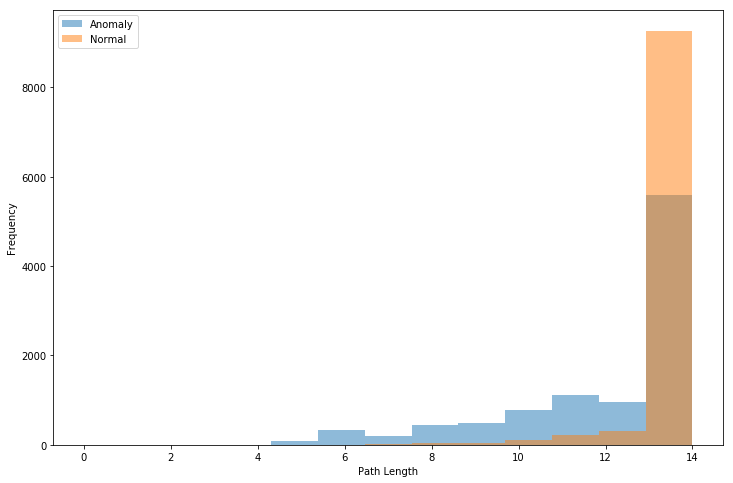

In [50]:
# Finally, we plot the path lengths.
bins = np.linspace(0, math.ceil(math.log(samples_size, 2)), math.ceil(math.log(samples_size, 2)))
plt.figure(figsize=(12,8))
plt.hist(posLenLst, bins, alpha=0.5, label='Anomaly')
plt.hist(negLenLst, bins, alpha=0.5, label='Normal')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

#### learn from this kernel

https://www.kaggle.com/rgaddati/unsupervised-fraud-detection-isolation-forest/notebook

#### paper

http://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf

## Local Outlier Factor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('~/person/analysis/python数据分析与数据化运营/chapter4/creditcard.csv')
y_true = data['Class']
datad = data.drop('Class', axis=1)

In [4]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8') 
from sklearn.neighbors import LocalOutlierFactor
k = 5; method = 1
clt = LocalOutlierFactor(n_neighbors=k+1,
                         algorithm='auto',
                        contamination=0.1,
                        n_jobs=-1)
clt.fit(datad)
datad['kd'] = clt.kneighbors(datad)[0].max(axis=1)
datad['lof'] = -clt._decision_function(datad)
# outliers = datad[datad['lof']>method].sort_values(by='lof')
# inliers = datad[datad['lof']<=method].sort_values(by='lof')
datad[datad['lof']>method]['class'] = 'outliers'
datad[datad['lof']<=method]['class'] = 'inliers'

In [9]:
res = clt.fit_predict(datad)

In [12]:
datad['Class'] = res

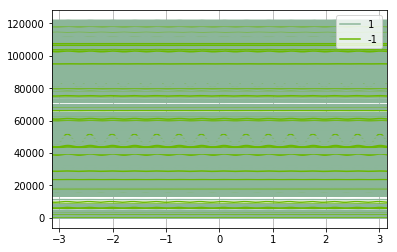

In [14]:
# Andrews曲线
pd.plotting.andrews_curves(datad.sample(1000), 'Class')

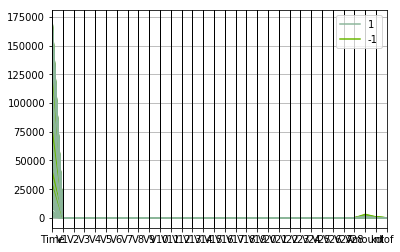

In [15]:
# 平行坐标
pd.plotting.parallel_coordinates(datad.sample(1000), 'Class')

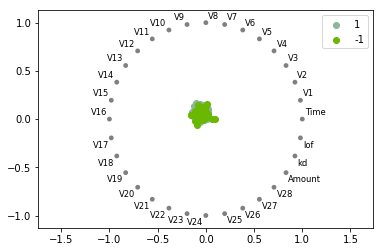

In [16]:
# RadViz雷达图
pd.plotting.radviz(datad.sample(1000), 'Class')

https://www.jianshu.com/p/3bb2cc453df1